### 安裝 facebook prophet

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet

### 讀取資料

In [ ]:
# read close
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
close = pd.read_csv('/content/drive/MyDrive/colabData/close.csv')
close.tail()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058,0059,0060,0061,006201,006202,006203,006204,006205,006206,006207,006208,00625K,00631L,00632R,00633L,00634R,00635U,00636,00636K,00637L,00638R,00639,00640L,00641R,00642U,00643,00643K,00645,00646,...,9908,9910,9911,9912,9914,9915,9917,9918,9919,9921,9922,9924,9925,9926,9927,9928,9929,9930,9931,9933,9934,9935,9937,9938,9939,9940,9941,9941A,9942,9943,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
3653,2022-02-14,NaN,142.70,60.2,133.50,68.55,30.76,26.04,33.13,99.55,NaN,NaN,NaN,21.55,21.30,NaN,68.20,89.85,35.64,34.41,28.11,82.30,NaN,143.10,5.16,49.84,4.12,24.55,24.06,8.67,19.78,8.50,14.88,27.97,10.28,16.78,17.59,NaN,25.57,38.02,...,33.00,221.0,68.2,9.75,278.0,NaN,101.5,42.4,25.85,302.5,NaN,42.20,39.4,48.60,38.10,6.80,9.46,45.05,39.50,40.20,14.70,18.55,48.85,80.4,75.6,34.50,185.5,51.3,90.6,60.4,21.85,67.5,14.90,12.65,9.90,75.0,18.60,110.0,26.70,16.10
3654,2022-02-15,NaN,142.05,60.2,133.00,68.75,30.75,26.05,33.10,99.60,NaN,NaN,NaN,21.50,21.48,NaN,68.25,89.60,35.66,34.45,28.24,82.00,NaN,142.05,5.17,49.67,4.13,24.90,24.05,8.63,19.70,8.53,15.05,27.35,10.42,16.79,17.80,NaN,25.27,37.72,...,32.95,218.0,68.1,9.86,278.5,NaN,102.5,42.1,25.50,300.0,NaN,42.20,39.3,48.60,38.20,6.78,9.49,45.00,39.25,40.65,14.70,18.75,49.00,80.6,75.7,34.45,187.0,51.3,91.0,60.5,21.90,67.5,14.95,12.65,10.45,74.8,20.45,108.5,26.80,16.05
3655,2022-02-16,NaN,144.40,61.0,135.40,69.70,30.98,26.19,33.27,100.40,NaN,NaN,NaN,21.60,21.78,NaN,68.70,90.95,36.05,34.77,28.54,83.30,NaN,147.00,5.09,50.60,4.09,24.54,24.30,8.68,20.08,8.44,15.27,28.25,10.22,16.31,18.06,NaN,25.71,38.31,...,33.00,224.5,68.1,9.84,280.5,NaN,103.5,42.1,25.50,301.5,NaN,42.50,39.4,51.60,38.25,6.68,9.44,44.90,39.25,41.00,14.70,19.20,49.30,80.8,76.5,34.75,192.0,51.3,91.6,60.8,21.90,67.8,15.05,12.80,11.30,75.7,18.70,109.5,26.80,16.10
3656,2022-02-17,NaN,144.50,61.2,135.60,69.60,31.20,26.20,33.34,100.85,NaN,NaN,NaN,21.77,21.71,NaN,69.10,91.25,36.18,34.93,28.69,83.25,NaN,147.35,5.08,50.80,4.08,24.85,24.43,8.75,20.20,8.43,15.31,27.91,10.30,16.42,18.17,NaN,25.49,38.17,...,33.00,224.0,68.2,9.66,279.5,NaN,103.5,42.3,25.35,300.5,NaN,42.65,39.5,49.10,38.60,6.80,9.46,45.20,39.25,41.10,14.80,18.90,49.95,80.5,76.5,34.80,192.0,51.4,91.0,60.8,21.95,68.8,14.70,12.70,11.20,76.0,20.55,110.5,26.75,16.05
3657,2022-02-18,NaN,144.10,61.4,134.85,69.80,31.06,26.19,33.50,100.75,NaN,NaN,NaN,21.80,21.84,NaN,68.90,91.40,36.27,35.05,28.71,82.95,NaN,147.30,5.08,51.00,4.07,25.03,24.39,8.71,20.25,8.44,15.28,27.71,10.31,16.17,18.10,NaN,25.51,37.85,...,33.00,222.5,67.5,9.67,280.0,NaN,103.0,42.3,25.45,299.5,NaN,42.60,39.5,48.95,38.50,6.90,9.50,45.35,39.35,41.45,14.85,18.95,49.45,80.5,76.9,34.65,193.5,51.3,91.2,61.6,22.10,69.9,14.75,12.90,11.90,77.3,22.60,111.5,26.75,16.30


In [ ]:
# 投信買賣超股數
investors = pd.read_csv('/content/drive/MyDrive/colabData/investors.csv')
print(investors.head(5))
print(investors.shape)

         date      0050  0051  0052  0053  ...     9951  9955  9958  9960  9962
0  2014-12-01       0.0   0.0   0.0   0.0  ...  30000.0   0.0   0.0   NaN   0.0
1  2014-12-02       0.0   0.0   0.0   0.0  ...  96000.0   0.0   0.0   NaN   NaN
2  2014-12-04       0.0   0.0   0.0   0.0  ... -47000.0   0.0   0.0   NaN   NaN
3  2014-12-05 -130000.0   0.0   0.0   0.0  ...      0.0   0.0   0.0   NaN   NaN
4  2014-12-08   50000.0   0.0   0.0   0.0  ...      0.0   NaN   0.0   NaN   NaN

[5 rows x 2224 columns]
(1740, 2224)


In [ ]:
# 自營商買賣超股數(自行買賣)
self_investors = pd.read_csv('/content/drive/MyDrive/colabData/self_investors.csv')
print(self_investors.head(5))
print(self_investors.shape)

         date       0050  0051  0052  0053  ...     9951  9955    9958  9960  9962
0  2014-12-01  2090000.0   0.0   0.0   0.0  ...   5000.0   0.0  3000.0   NaN   0.0
1  2014-12-02   744000.0   0.0   0.0   0.0  ...  10000.0   0.0 -1000.0   NaN   NaN
2  2014-12-04   -50000.0   0.0   0.0   0.0  ...  -2000.0   0.0 -1000.0   NaN   NaN
3  2014-12-05   280000.0   0.0   0.0   0.0  ...  14000.0   0.0 -2000.0   NaN   NaN
4  2014-12-08 -1474000.0   0.0   0.0   0.0  ...   3000.0   NaN     0.0   NaN   NaN

[5 rows x 2224 columns]
(1740, 2224)


In [ ]:
# 外陸資買賣超股數(不含外資自營商)
foreign_investors = pd.read_csv('/content/drive/MyDrive/colabData/foreign_investors.csv')
print(foreign_investors.head(5))
print(foreign_investors.shape)

         date  0050  0051  0052  0053  ...      9951  9955  9958  9960   9962
0  2014-12-01   0.0   0.0   0.0   0.0  ...  -21000.0   0.0   0.0   NaN -483.0
1  2014-12-02   0.0   0.0   0.0   0.0  ...   53000.0   0.0   0.0   NaN    NaN
2  2014-12-04   0.0   0.0   0.0   0.0  ...   74000.0   0.0   0.0   NaN    NaN
3  2014-12-05   0.0   0.0   0.0   0.0  ...   61000.0   0.0   0.0   NaN    NaN
4  2014-12-08   0.0   0.0   0.0   0.0  ...  112000.0   NaN   0.0   NaN    NaN

[5 rows x 2224 columns]
(1740, 2224)


### 提取所需的股票資料

In [ ]:
# filter the close
data = close[(close['date'] > "2017-12-28")]
data_close = data[['date', '0050']]
data_close.reset_index(inplace=True, drop=True)
print(data_close.shape)

# filter the investor
data = investors[(investors['date'] > "2017-12-28")]
data_investor = data[['date', '0050']]
data_investor.reset_index(inplace=True, drop=True)
print(data_investor.shape)

# filter the self_investors
data = self_investors[(self_investors['date'] > "2017-12-28")]
data_self_investor = data[['date', '0050']]
data_self_investor.reset_index(inplace=True, drop=True)
print(data_self_investor.shape)

# filter the foreign_investors
data = foreign_investors[(foreign_investors['date'] > "2017-12-28")]
data_foreign_investor = data[['date', '0050']]
data_foreign_investor.reset_index(inplace=True, drop=True)
print(data_foreign_investor.shape)

(1007, 2)
(989, 2)
(989, 2)
(989, 2)


In [ ]:
def fillNull(dfClose, df):
  import numpy as np
  # get date tracker
  date_tracker = dfClose['date'].values
  date_follow = df['date'].values

  while(len(date_tracker) > len(date_follow)):
    for i in range(len(date_tracker)):
      if(date_tracker[i] != date_follow[i]):
        #print("loss date:", date_tracker[i])

        insert_df = pd.DataFrame({
          'date': date_tracker[i],
          '0050': [np.nan]
        })

        head = df.iloc[:i, :]
        tail = df.iloc[i:, :]

        tmp  =  pd.concat([head, insert_df])
        df  = pd.concat([tmp, tail])
        df.reset_index(inplace=True, drop=True)

        date_follow = df['date'].values
        break
  return df

# process data
train_investor = fillNull(data_close, data_investor)
train_investor = train_investor.rename(columns={'0050': 'y', 'date': 'ds'}, inplace=False)
train_investor = train_investor.interpolate(method='linear', limit_direction='forward', axis=0)
print(len(train_investor))

train_self_investor = fillNull(data_close, data_self_investor)
train_self_investor = train_self_investor.rename(columns={'0050': 'y', 'date': 'ds'}, inplace=False)
train_self_investor = train_self_investor.interpolate(method='linear', limit_direction='forward', axis=0)
print(len(train_self_investor))

train_foreign_investor = fillNull(data_close, data_foreign_investor)
train_foreign_investor = train_foreign_investor.rename(columns={'0050': 'y', 'date': 'ds'}, inplace=False)
train_foreign_investor = train_foreign_investor.interpolate(method='linear', limit_direction='forward', axis=0)
print(len(train_foreign_investor))

1007
1007
1007


In [ ]:
# process data
train_close = data_close.rename(columns={'0050': 'y', 'date': 'ds'}, inplace=False)
train_close = train_close.interpolate(method='linear', limit_direction='forward', axis=0)
print(train_close.tail())
print(len(train_close))

              ds       y
1002  2022-02-14  142.70
1003  2022-02-15  142.05
1004  2022-02-16  144.40
1005  2022-02-17  144.50
1006  2022-02-18  144.10
1007


### ProPhet 預測

In [ ]:
from prophet import Prophet

m_investor = Prophet()
m_investor.fit(train_investor)

future = m_investor.make_future_dataframe(periods=30)
forecast = m_investor.predict(future)

pred_investor = forecast[['ds', 'yhat']]

pred_investor.tail(3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
1034,2022-03-18,-27458.378479
1035,2022-03-19,-25744.628033
1036,2022-03-20,-10865.387048


In [ ]:
m_self_investor = Prophet()
m_self_investor.fit(train_self_investor)

future = m_self_investor.make_future_dataframe(periods=30)
forecast = m_self_investor.predict(future)

pred_self_investor = forecast[['ds', 'yhat']]

pred_self_investor.tail(3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
1034,2022-03-18,-102312.752730
1035,2022-03-19,-156485.762275
1036,2022-03-20,10196.942623


In [ ]:
m_foreign_investor = Prophet()
m_foreign_investor.fit(train_foreign_investor)

future = m_foreign_investor.make_future_dataframe(periods=30)
forecast = m_foreign_investor.predict(future)

pred_foreign_investor = forecast[['ds', 'yhat']]

pred_foreign_investor.tail(3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
1034,2022-03-18,-2.307739e+06
1035,2022-03-19,-3.748671e+06
1036,2022-03-20,-4.558482e+05


### 多變量預測模組

In [ ]:
# 拼接訓練資料
print("train_investor")
print(train_investor.tail(3))
print("=========================")

tmp = train_investor.rename(columns={'y': 'investor'}, inplace=False)
tmp = tmp.drop(columns=['ds'])
print("tmp")
print(tmp.tail(3))
print("=========================")

print("train_close")
print(train_close.tail(3))
print("=========================")

train = train_close.merge(tmp, how='inner', left_index=True, right_index=True)
print("train")
print(train.tail(3))
print("=========================")

tmp = train_self_investor.rename(columns={'y': 'self_investor'}, inplace=False)
tmp = tmp.drop(columns=['ds'])

train = train.merge(tmp, how='inner', left_index=True, right_index=True)
print(train.tail(3))

tmp = train_foreign_investor.rename(columns={'y': 'foreign_investor'}, inplace=False)
tmp = tmp.drop(columns=['ds'])

train = train.merge(tmp, how='inner', left_index=True, right_index=True)
print(train.tail(3))

train_investor
              ds         y
1004  2022-02-16  334000.0
1005  2022-02-17   10000.0
1006  2022-02-18       0.0
tmp
      investor
1004  334000.0
1005   10000.0
1006       0.0
train_close
              ds      y
1004  2022-02-16  144.4
1005  2022-02-17  144.5
1006  2022-02-18  144.1
train
              ds      y  investor
1004  2022-02-16  144.4  334000.0
1005  2022-02-17  144.5   10000.0
1006  2022-02-18  144.1       0.0
              ds      y  investor  self_investor
1004  2022-02-16  144.4  334000.0       896050.0
1005  2022-02-17  144.5   10000.0       661134.0
1006  2022-02-18  144.1       0.0        49950.0
              ds      y  investor  self_investor  foreign_investor
1004  2022-02-16  144.4  334000.0       896050.0         -382540.0
1005  2022-02-17  144.5   10000.0       661134.0          347572.0
1006  2022-02-18  144.1       0.0        49950.0        -1203394.0


In [ ]:
# 訓練模型

m = Prophet()

# 增加額外回歸標量
m.add_regressor('self_investor')
m.add_regressor('investor')
m.add_regressor('foreign_investor')

m.fit(train)

f = m.make_future_dataframe(periods=30)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# merge future regression index
tmp = pred_foreign_investor.rename(columns={'yhat': 'foreign_investor'}, inplace=True)
tmp = pred_foreign_investor.drop(columns=['ds'])

future = f.merge(tmp, how='inner', left_index=True, right_index=True)
print(future.tail())

tmp = pred_self_investor.rename(columns={'yhat': 'self_investor'}, inplace=True)
tmp = pred_self_investor.drop(columns=['ds'])

future = future.merge(tmp, how='inner', left_index=True, right_index=True)
print(future.tail())

tmp = pred_investor.rename(columns={'yhat': 'investor'}, inplace=True)
tmp = pred_investor.drop(columns=['ds'])

future = future.merge(tmp, how='inner', left_index=True, right_index=True)
print(future.tail())

             ds  foreign_investor
1032 2022-03-16     -1.960201e+06
1033 2022-03-17     -2.613358e+06
1034 2022-03-18     -2.307739e+06
1035 2022-03-19     -3.748671e+06
1036 2022-03-20     -4.558482e+05
             ds  foreign_investor  self_investor
1032 2022-03-16     -1.960201e+06 -191587.676803
1033 2022-03-17     -2.613358e+06 -113971.977287
1034 2022-03-18     -2.307739e+06 -102312.752730
1035 2022-03-19     -3.748671e+06 -156485.762275
1036 2022-03-20     -4.558482e+05   10196.942623
             ds  foreign_investor  self_investor      investor
1032 2022-03-16     -1.960201e+06 -191587.676803 -39424.051219
1033 2022-03-17     -2.613358e+06 -113971.977287 -63113.466596
1034 2022-03-18     -2.307739e+06 -102312.752730 -27458.378479
1035 2022-03-19     -3.748671e+06 -156485.762275 -25744.628033
1036 2022-03-20     -4.558482e+05   10196.942623 -10865.387048


In [ ]:
forecast = m.predict(future)
y_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(len(y_pred))

1037


### 誤差統計

In [ ]:
# filter the date
filter = y_pred[(y_pred['ds'] <= "2022-02-18")]
yhat = filter['yhat'].values
print(len(yhat))

y = train['y'].values
print(len(y))

1007
1007


In [ ]:
mse = 0
for i in range(len(y)):
  mse = mse + (y[i] - yhat[i])**2.0
mse = mse / len(y)
print("mse:", mse)

rmse = np.sqrt(mse)
print("rmse: ", rmse)

mse: 4.356945850803542
rmse:  2.0873298375684524


### 繪圖

In [ ]:
# filter the date
pred_plot_data = y_pred[(y_pred['ds'] >= "2021-01-03")]
pred_plot_data.reset_index(inplace=True, drop=True)
pred_plot_data.tail()

,ds,yhat,yhat_lower,yhat_upper
297,2022-03-16,141.204674,138.538567,143.730170
298,2022-03-17,141.009860,138.356605,143.783294
299,2022-03-18,140.811225,138.170928,143.541722
300,2022-03-19,142.111370,139.361898,144.524912
301,2022-03-20,143.036714,140.582054,145.683709


In [ ]:
import numpy as np
filter = future
filter['y'] = np.nan
filter['y'] = train['y']

raw_plot_data = filter[(filter['ds'] >= "2021-01-03")]
raw_plot_data.reset_index(inplace=True, drop=True)
raw_plot_data.tail()

,ds,foreign_investor,self_investor,investor,y
297,2022-03-16,-1.960201e+06,-191587.676803,-39424.051219,NaN
298,2022-03-17,-2.613358e+06,-113971.977287,-63113.466596,NaN
299,2022-03-18,-2.307739e+06,-102312.752730,-27458.378479,NaN
300,2022-03-19,-3.748671e+06,-156485.762275,-25744.628033,NaN
301,2022-03-20,-4.558482e+05,10196.942623,-10865.387048,NaN


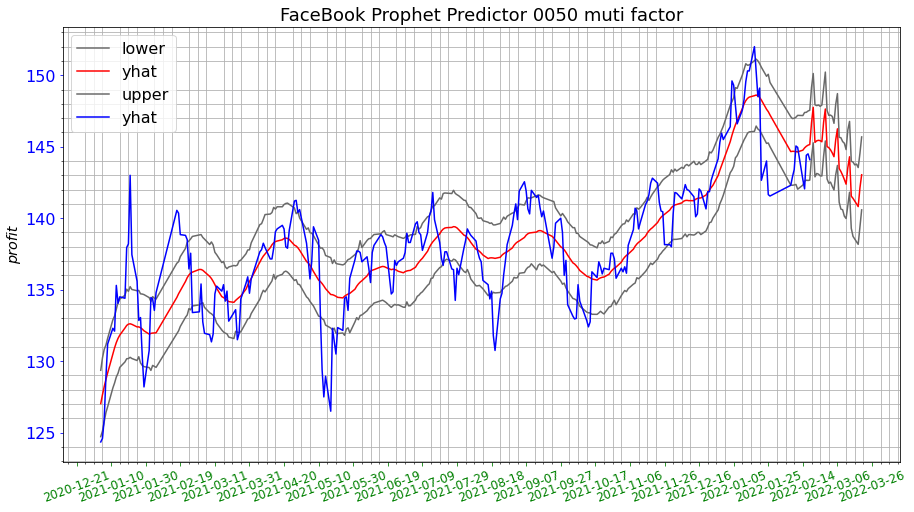

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(15,8)) #create figure
ax = fig.add_subplot(1, 1, 1) #create ax within figure

ax.plot(pred_plot_data['ds'], pred_plot_data['yhat_lower'], color='dimgray', label='lower')
ax.plot(pred_plot_data['ds'], pred_plot_data['yhat'], color='red', label='yhat')
ax.plot(pred_plot_data['ds'], pred_plot_data['yhat_upper'], color='dimgray', label='upper')
ax.plot(pred_plot_data['ds'], raw_plot_data['y'], color='blue', label='yhat')

ax.xaxis.set_major_locator(ticker.MultipleLocator(20)) #set xTicks interval
ax.xaxis.set_tick_params(rotation=20,labelsize=12,colors='g') #setting xticks
ax.yaxis.set_tick_params(labelsize=16,colors='b') #setting xticks
ax.minorticks_on()

ax.grid(which='minor', axis='both')
ax.set_title('FaceBook Prophet Predictor 0050 muti factor',fontsize=18)
ax.set_ylabel('profit', fontsize='x-large',fontstyle='oblique')
ax.legend(fontsize=16)